## Import Data 

In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
df = pd.read_csv(r"bloodpressurestudy.csv",index_col="subject")

In [15]:
df

,drug,before,after
subject,,,
1,Ramipril,194,157
2,Ramipril,162,136
3,Ramipril,183,145
4,Ramipril,180,153
5,Lisinopril,154,124
6,Lisinopril,184,123
7,Lisinopril,173,143
8,Lisinopril,170,136
9,Moexipril,158,124


## Exploratory Data Analysis

In [16]:
#Summary Statistics
df.describe()

,before,after
count,12.000000,12.000000
mean,174.250000,135.833333
std,12.512721,11.621558
min,154.000000,123.000000
25%,164.250000,124.000000
50%,176.500000,134.500000
75%,183.250000,143.500000
max,194.000000,157.000000


In [91]:
# Group-wise descriptive stats for before/after SBP
group_stats = df.groupby("drug")[["before", "after"]].describe().round(2)
group_stats


C:\Users\attafuro\AppData\Local\Temp\ipykernel_7616\1393088068.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby("drug")[["before", "after"]].describe().round(2)


before                                                     after  \
            count    mean    std    min     25%    50%     75%    max count   
drug                                                                          
Ramipril      4.0  179.75  13.28  162.0  175.50  181.5  185.75  194.0   4.0   
Lisinopril    4.0  170.25  12.39  154.0  166.00  171.5  175.75  184.0   4.0   
Moexipril     4.0  172.75  13.40  158.0  163.25  173.5  183.00  186.0   4.0   

                                                               
              mean   std    min     25%    50%     75%    max  
drug                                                           
Ramipril    147.75  9.29  136.0  142.75  149.0  154.00  157.0  
Lisinopril  131.50  9.68  123.0  123.75  130.0  137.75  143.0  
Moexipril   128.25  4.92  124.0  124.00  128.0  132.25  133.0

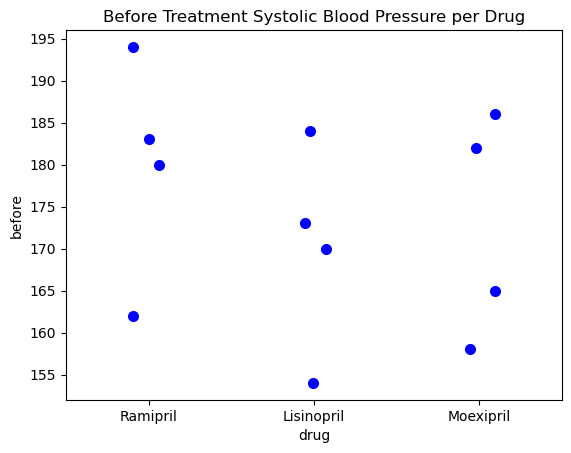

In [76]:
##Dot Plot

sns.stripplot(x="drug" , y="before" , data = df , color = "blue" , jitter = True , size = 8)
plt.title("Before Treatment Systolic Blood Pressure per Drug")
plt.savefig("img1.png", dpi=300, bbox_inches="tight")
plt.show()

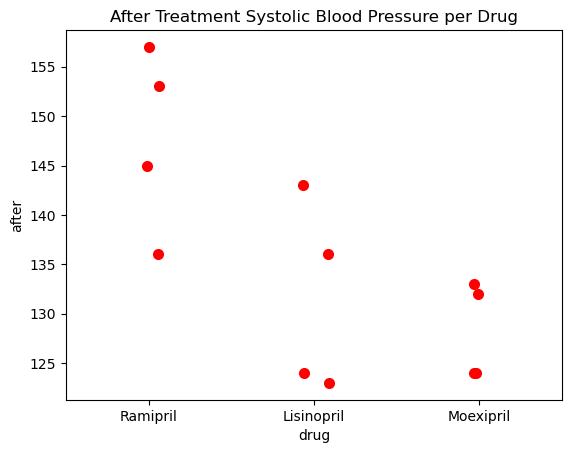

In [77]:
sns.stripplot(x="drug" , y="after" , data = df , jitter = True , color = "red" , size = 8)
plt.title("After Treatment Systolic Blood Pressure per Drug")
plt.savefig("img2.png", dpi=300, bbox_inches="tight")
plt.show()

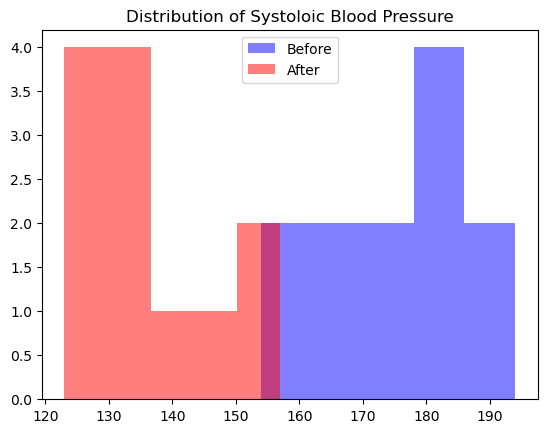

In [78]:
plt.hist(df["before"], bins = 5, alpha = 0.5 , label = "Before" ,  color = "blue" )
plt.hist(df["after"] ,  bins = 5, alpha = 0.5 , label = "After" , color = "red")
plt.legend()
plt.title("Distribution of Systoloic Blood Pressure")
plt.savefig("img3.png", dpi=300, bbox_inches="tight")
plt.show()

In [28]:
df["difference"] = df["after"] - df["before"]
print(df.groupby("drug")["difference"].describe())

            count   mean        std   min    25%   50%    75%   max
drug                                                               
Lisinopril    4.0 -38.75  14.952703 -61.0 -40.75 -32.0 -30.00 -30.0
Moexipril     4.0 -44.50   8.812869 -54.0 -50.25 -45.0 -39.25 -34.0
Ramipril      4.0 -32.00   6.377042 -38.0 -37.25 -32.0 -26.75 -26.0


C:\Users\attafuro\AppData\Local\Temp\ipykernel_7616\1476474855.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(


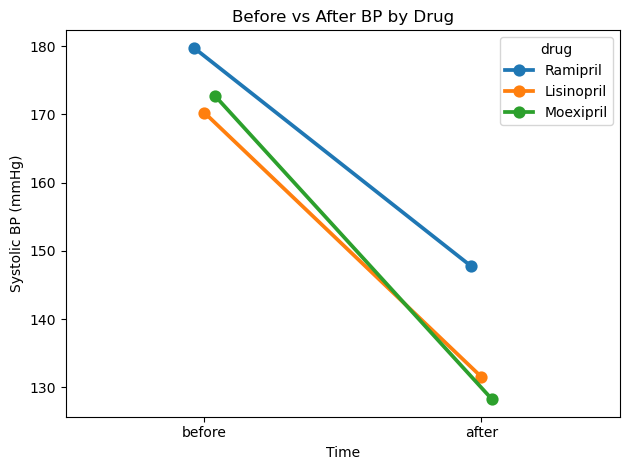

In [35]:
# If 'subject' is not a column (because it was used as index), bring it back
if "subject" not in df.columns:
    df = df.reset_index()  # this will restore the index as a column named by its index name (likely 'subject')

# Melt to long format for Before/After plotting
df_melted = df.melt(
    id_vars=["subject", "drug"],
    value_vars=["before", "after"],
    var_name="time",
    value_name="bp"
)

# Ensure the x-axis shows 'before' then 'after' in the right order
df_melted["time"] = pd.Categorical(df_melted["time"], categories=["before", "after"], ordered=True)

# Plot mean BP per drug, connected from before→after (classic interaction plot)
sns.pointplot(
    x="time", y="bp", hue="drug",
    data=df_melted,
    ci=None, markers="o", dodge=True, capsize=.1
)

plt.title("Before vs After BP by Drug")
plt.xlabel("Time")
plt.ylabel("Systolic BP (mmHg)")
plt.tight_layout()
plt.show()


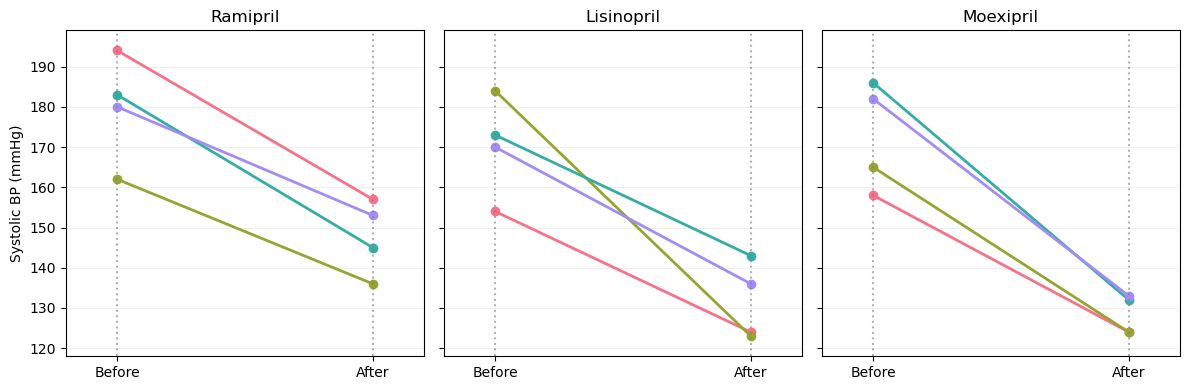

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- make sure 'subject' is a column ---
if "subject" not in df.columns:
    df = df.reset_index()

# order drugs (change if you prefer a different order)
drug_order = ["Ramipril", "Lisinopril", "Moexipril"]
drug_order = [d for d in drug_order if d in df["drug"].unique()]  # keep only those present

# x positions for before/after
x = np.array([0, 1])
xlabels = ["Before", "After"]

# y range shared across panels (with a little padding)
ymin = min(df["before"].min(), df["after"].min()) - 5
ymax = max(df["before"].max(), df["after"].max()) + 5

# figure + axes
fig, axes = plt.subplots(1, len(drug_order), figsize=(12, 4), sharey=True)

if len(drug_order) == 1:
    axes = [axes]  # ensure iterable

for ax, drug in zip(axes, drug_order):
    dsub = df[df["drug"] == drug].copy()

    # color per subject within each drug
    colors = sns.color_palette("husl", n_colors=len(dsub))

    for (idx, row), c in zip(dsub.iterrows(), colors):
        ax.plot(x, [row["before"], row["after"]],
                marker="o", lw=2, color=c)

    # cosmetics
    ax.set_title(drug)
    ax.set_xlim(-0.2, 1.2)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_ylim(ymin, ymax)

    # light vertical guides like in papers
    ax.axvline(0, ls=":", color="grey", alpha=0.6)
    ax.axvline(1, ls=":", color="grey", alpha=0.6)
    ax.grid(axis="y", alpha=0.2)

axes[0].set_ylabel("Systolic BP (mmHg)")
plt.tight_layout()
plt.savefig("img4.png", dpi=300, bbox_inches="tight")
plt.show()


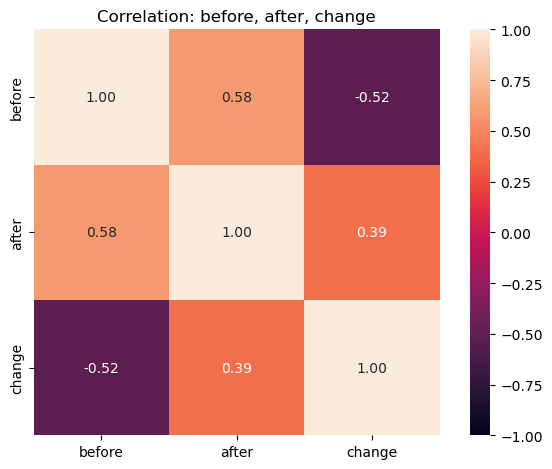

In [80]:
corr = df[["before", "after", "change"]].corr(method="pearson")
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, square=True)
plt.title("Correlation: before, after, change")
plt.tight_layout()
plt.savefig("img5.png", dpi=300, bbox_inches="tight")
plt.show()


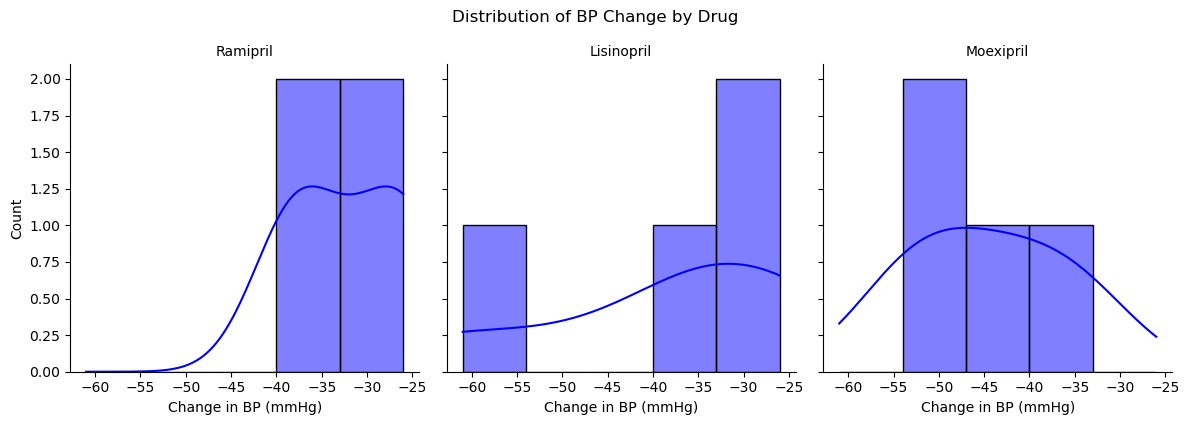

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure change column exists
df["change"] = df["after"] - df["before"]

# Faceted histograms of change per drug
g = sns.displot(
    data=df,
    x="change",
    col="drug",
    bins=5,
    kde=True,   # adds a smooth density curve overlay
    color="blue",
    height=4,
    aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Change in BP (mmHg)", "Count")
plt.suptitle("Distribution of BP Change by Drug", y=1.05)
plt.show()


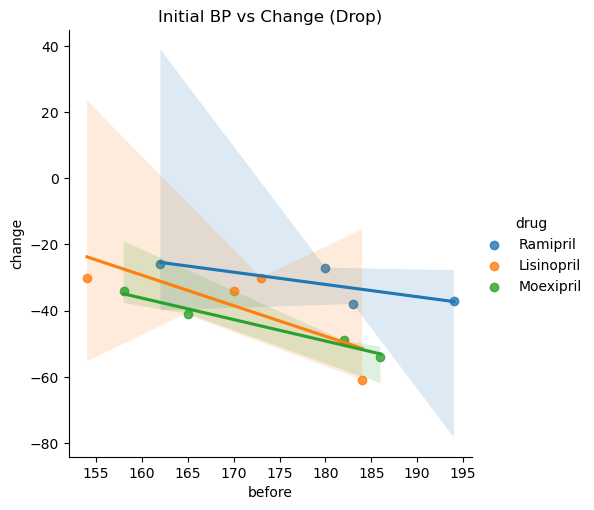

In [41]:
sns.lmplot(x="before", y="change", hue="drug", data=df, fit_reg=True)
plt.title("Initial BP vs Change (Drop)")
plt.show()


## Baseline Check

This we use Anova, to use ANOVA we first need to ensure the key assumptions are met. 

In [45]:
##Normality Test
for g, dsub in df.groupby("drug"):
    w, p = stats.shapiro(dsub["before"])
    print(f"{g}: Shapiro p = {p:.3f}")
##If p > 0.05 normal 

Lisinopril: Shapiro p = 0.828
Moexipril: Shapiro p = 0.452
Ramipril: Shapiro p = 0.758


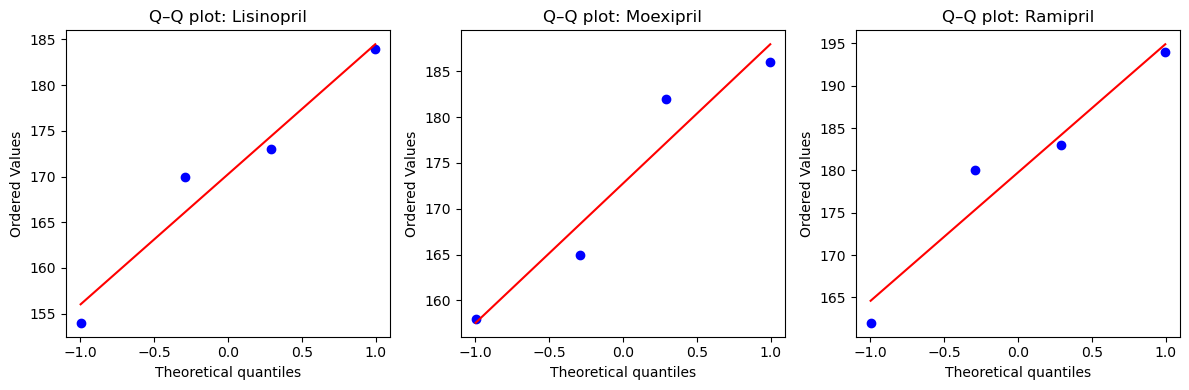

In [47]:
fig, axes = plt.subplots(1, df['drug'].nunique(), figsize=(12,4))
if not isinstance(axes, np.ndarray): axes = [axes]

for ax, (g, dsub) in zip(axes, df.groupby('drug')):
    stats.probplot(dsub['before'], dist="norm", plot=ax)
    ax.set_title(f"Q–Q plot: {g}")
plt.tight_layout()
plt.show()


In [46]:
## Equality of Variance 

groups = [d["before"].values for _, d in df.groupby("drug")]
lev_stat, lev_p = stats.levene(*groups, center="median")
print(f"Levene p = {lev_p:.3f}")

#If p>0.05 then equality of variance assumption met

Levene p = 0.822


In [50]:
##Baseline test
f, p = stats.f_oneway(*groups)
print(f"ANOVA on baseline: p = {p:.3f}")


ANOVA on baseline: p = 0.584


In [51]:
## Model One ( ANOVA)

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Create the change variable if not already there
df["change"] = df["after"] - df["before"]

# Fit one-way ANOVA using OLS regression
model_change = smf.ols("change ~ C(drug)", data=df).fit()

# ANOVA table (Type II SS)
anova_tbl = sm.stats.anova_lm(model_change, typ=2)
print("ANOVA Table:\n", anova_tbl)

# Model summary (includes R², AIC, BIC)
print("\nModel Summary:\n", model_change.summary())

# Effect size (eta-squared)
ss_between = anova_tbl.loc["C(drug)", "sum_sq"]
ss_total   = ss_between + anova_tbl.loc["Residual", "sum_sq"]
eta_sq = ss_between / ss_total
print(f"\nEta-squared (effect size) = {eta_sq:.3f}")


ANOVA Table:
                sum_sq   df         F    PR(>F)
C(drug)    313.166667  2.0  1.373873  0.301506
Residual  1025.750000  9.0       NaN       NaN

Model Summary:
                             OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1.374
Date:                Sat, 30 Aug 2025   Prob (F-statistic):              0.302
Time:                        18:53:43   Log-Likelihood:                -43.717
No. Observations:                  12   AIC:                             93.43
Df Residuals:                       9   BIC:                             94.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


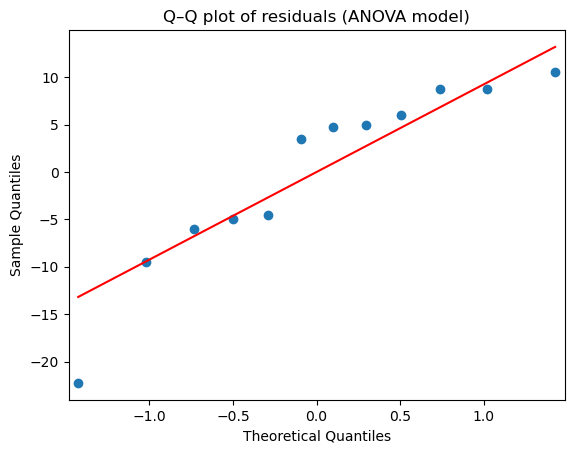

In [81]:
## Model Diagnostics for model One
import matplotlib.pyplot as plt
import scipy.stats as stats

sm.qqplot(model_change.resid, line="s")
plt.title("Q–Q plot of residuals (ANOVA model)")
plt.savefig("img6.png", dpi=300, bbox_inches="tight")
plt.show()


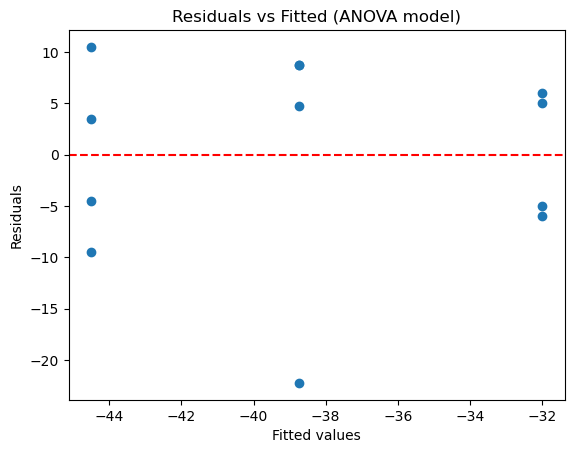

In [82]:
plt.scatter(model_change.fittedvalues, model_change.resid)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (ANOVA model)")
plt.savefig("img7.png", dpi=300, bbox_inches="tight")
plt.show()


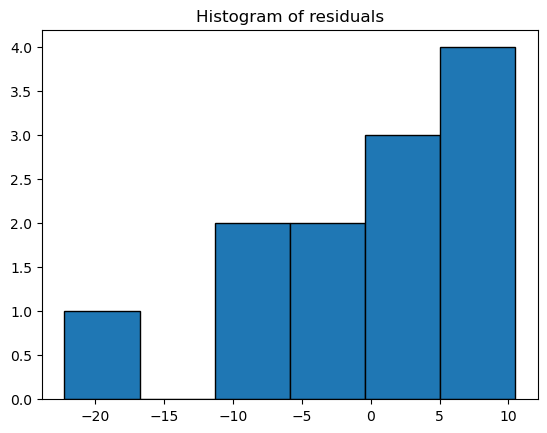

In [54]:
plt.hist(model_change.resid, bins=6, edgecolor="k")
plt.title("Histogram of residuals")
plt.show()


In [75]:
import pandas as pd
from scipy import stats

# List unique drug groups
drugs = df['drug'].unique()

results = []
for drug in drugs:
    # Subset data for this drug
    sub_df = df[df['drug'] == drug]

    # Paired t-test (baseline vs after treatment)
    t_stat, p_val = stats.ttest_rel(sub_df['before'], sub_df['after'])

    results.append({
        "Drug": drug,
        "t-statistic": t_stat,
        "p-value": p_val
    })

# Convert results into a nice table
results_df = pd.DataFrame(results)
print(results_df)


         Drug  t-statistic   p-value
0    Ramipril    10.036001  0.002106
1  Lisinopril     5.183009  0.013944
2   Moexipril    10.098867  0.002068


In [55]:
## MODEL TWO ( ANOVA WITH INTERACTIONS)


df_long = df.melt(id_vars=["subject", "drug"], 
                  value_vars=["before","after"], 
                  var_name="time", value_name="bp")

print(df_long.head(8))


   subject        drug    time   bp
0        1    Ramipril  before  194
1        2    Ramipril  before  162
2        3    Ramipril  before  183
3        4    Ramipril  before  180
4        5  Lisinopril  before  154
5        6  Lisinopril  before  184
6        7  Lisinopril  before  173
7        8  Lisinopril  before  170


C:\Users\attafuro\AppData\Local\Temp\ipykernel_7616\2931548259.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x="time", y="bp", hue="drug", data=df_long,


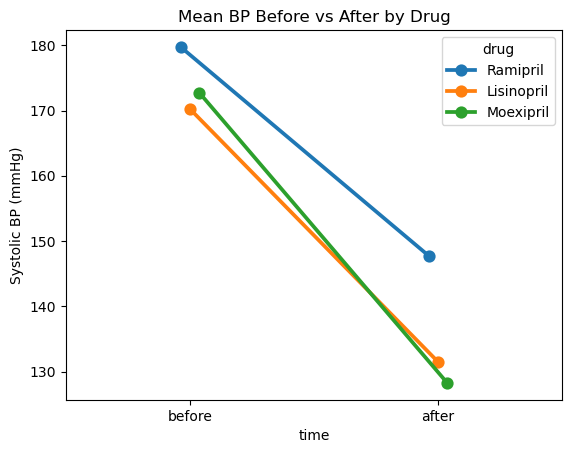

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pointplot(x="time", y="bp", hue="drug", data=df_long,
              ci=None, dodge=True, markers="o")
plt.title("Mean BP Before vs After by Drug")
plt.ylabel("Systolic BP (mmHg)")
plt.show()


In [57]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Model: bp ~ drug * time
model_interaction = ols("bp ~ C(drug) * C(time)", data=df_long).fit()

anova_tbl = sm.stats.anova_lm(model_interaction, typ=2)
print(anova_tbl)

# model summary (R², AIC, BIC)
print(model_interaction.summary())


                      sum_sq    df          F        PR(>F)
C(drug)           910.583333   2.0   3.828214  4.118003e-02
C(time)          8855.041667   1.0  74.455565  8.207923e-08
C(drug):C(time)   156.583333   2.0   0.658297  5.297579e-01
Residual         2140.750000  18.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                     bp   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     16.69
Date:                Sat, 30 Aug 2025   Prob (F-statistic):           3.32e-06
Time:                        18:58:14   Log-Likelihood:                -87.945
No. Observations:                  24   AIC:                             187.9
Df Residuals:                      18   BIC:                             195.0
Df Model:                           5                               

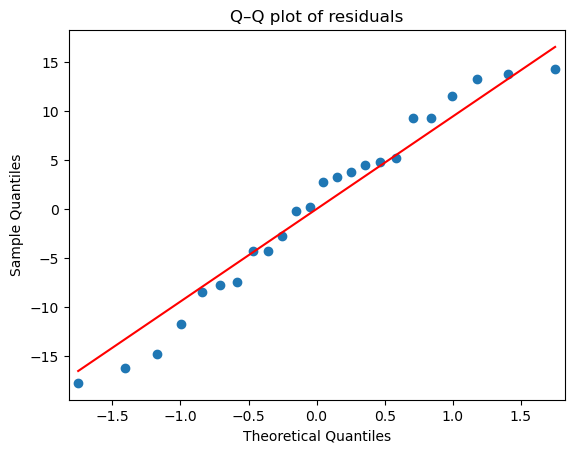

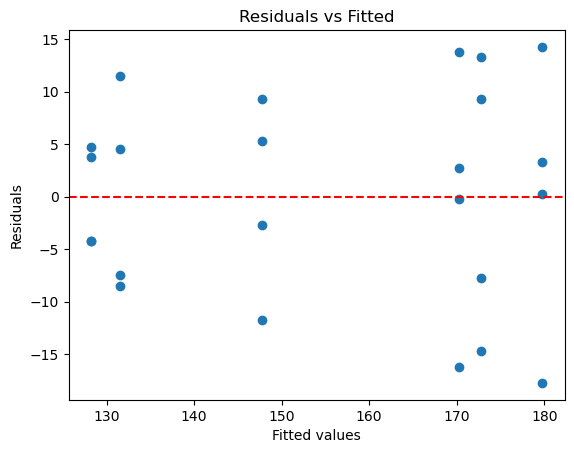

In [89]:
# Q–Q plot
sm.qqplot(model_interaction.resid, line="s")
plt.title("Q–Q plot of residuals")
plt.savefig("img8.png", dpi=300, bbox_inches="tight")
plt.savefig("img13.png", dpi=300, bbox_inches="tight")
plt.show()

# Residuals vs fitted
plt.scatter(model_interaction.fittedvalues, model_interaction.resid)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.savefig("img8.png", dpi=300, bbox_inches="tight")
plt.show()


In [59]:
## MOdel 3 - ANCOVA MODEL

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model: After ~ Before + Drug
model_ancova = smf.ols("after ~ before + C(drug)", data=df).fit()

# ANOVA table (Type II SS)
anova_tbl = sm.stats.anova_lm(model_ancova, typ=2)
print("ANCOVA Table:\n", anova_tbl)

# Model summary (includes R², AIC, BIC, coefficients, SEs)
print("\nModel Summary:\n", model_ancova.summary())


ANCOVA Table:
               sum_sq   df         F    PR(>F)
C(drug)   569.477044  2.0  5.567742  0.030549
before    203.373957  1.0  3.976749  0.081246
Residual  409.126043  8.0       NaN       NaN

Model Summary:
                             OLS Regression Results                            
Dep. Variable:                  after   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     7.017
Date:                Sat, 30 Aug 2025   Prob (F-statistic):             0.0125
Time:                        19:05:39   Log-Likelihood:                -38.202
No. Observations:                  12   AIC:                             84.40
Df Residuals:                       8   BIC:                             86.34
Df Model:                           3                                         
Covariance Type:            nonrobust                                    

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


In [60]:
print(f"R-squared: {model_ancova.rsquared:.3f}")
print(f"AIC: {model_ancova.aic:.3f}")
print(f"BIC: {model_ancova.bic:.3f}")

R-squared: 0.725
AIC: 84.404
BIC: 86.344


In [61]:
ss_drug = anova_tbl.loc["C(drug)", "sum_sq"]
ss_total = sum(anova_tbl["sum_sq"])
eta_sq_drug = ss_drug / ss_total
print(f"Partial Eta-squared (Drug effect) = {eta_sq_drug:.3f}")

Partial Eta-squared (Drug effect) = 0.482


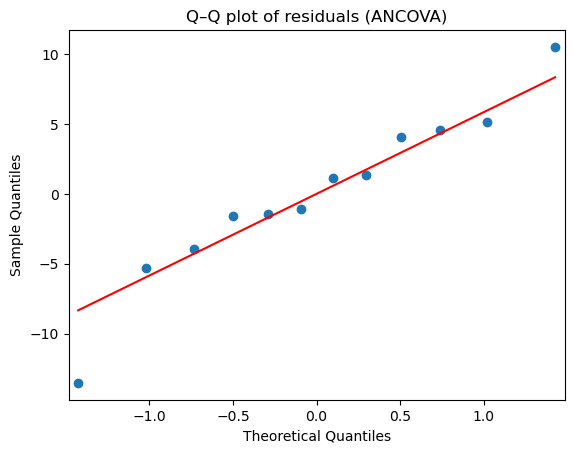

In [84]:
sm.qqplot(model_ancova.resid, line="s")
plt.title("Q–Q plot of residuals (ANCOVA)")
plt.savefig("img9.png", dpi=300, bbox_inches="tight")
plt.show()

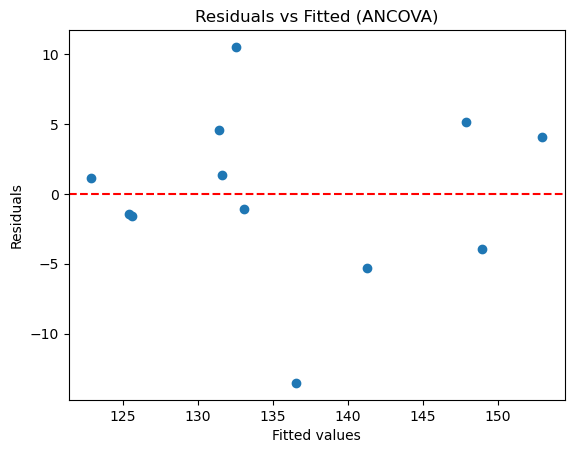

In [85]:
plt.scatter(model_ancova.fittedvalues, model_ancova.resid)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (ANCOVA)")
plt.savefig("img10.png", dpi=300, bbox_inches="tight")
plt.show()

In [64]:
## ANCOVA MODEL WITH INTERACTIONS
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model: After ~ Before * Drug (interaction allowed)
model_ancova_int = smf.ols("after ~ before * C(drug)", data=df).fit()

# ANOVA table (Type II SS)
anova_tbl_int = sm.stats.anova_lm(model_ancova_int, typ=2)
print("ANCOVA with interaction Table:\n", anova_tbl_int)

# Model summary (R², AIC, BIC, coefficients, SEs)
print("\nModel Summary:\n", model_ancova_int.summary())


ANCOVA with interaction Table:
                     sum_sq   df         F    PR(>F)
C(drug)         569.477044  2.0  5.116880  0.050489
before          203.373957  1.0  3.654722  0.104457
before:C(drug)   75.244633  2.0  0.676090  0.543507
Residual        333.881410  6.0       NaN       NaN

Model Summary:
                             OLS Regression Results                            
Dep. Variable:                  after   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     4.140
Date:                Sat, 30 Aug 2025   Prob (F-statistic):             0.0565
Time:                        19:07:32   Log-Likelihood:                -36.983
No. Observations:                  12   AIC:                             85.97
Df Residuals:                       6   BIC:                             88.87
Df Model:                           5                      

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


In [65]:
print(f"R-squared: {model_ancova_int.rsquared:.3f}")
print(f"AIC: {model_ancova_int.aic:.3f}")
print(f"BIC: {model_ancova_int.bic:.3f}")

R-squared: 0.775
AIC: 85.965
BIC: 88.875


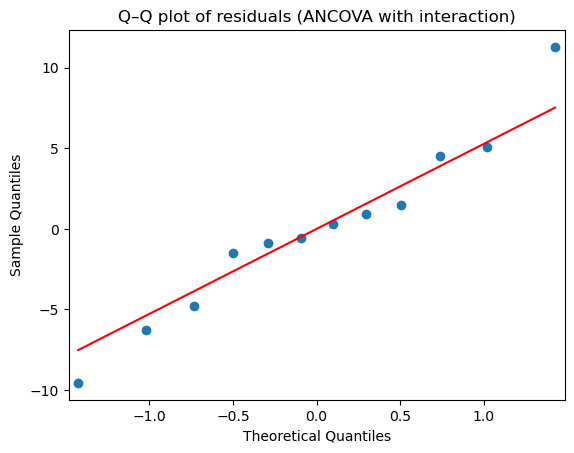

In [86]:
sm.qqplot(model_ancova_int.resid, line="s")
plt.title("Q–Q plot of residuals (ANCOVA with interaction)")
plt.savefig("img11.png", dpi=300, bbox_inches="tight")
plt.show()

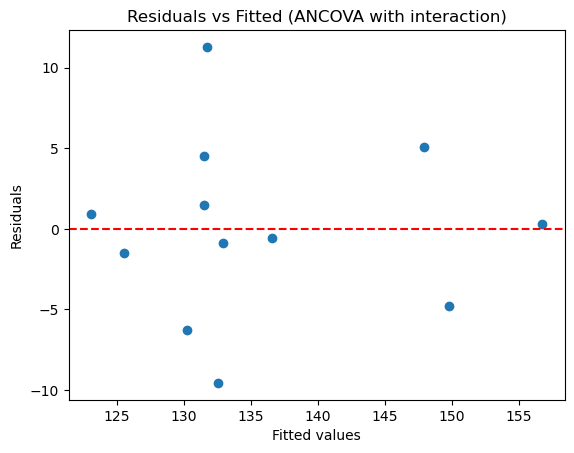

In [87]:
plt.scatter(model_ancova_int.fittedvalues, model_ancova_int.resid)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (ANCOVA with interaction)")
plt.savefig("img12.png", dpi=300, bbox_inches="tight")
plt.show()


In [70]:
import pandas as pd

models = {
    "Change-score ANOVA": model_change,
    "ANOVA (Drug × Time)": model_interaction,
    "ANCOVA (equal slopes)": model_ancova,
    "ANCOVA (with interaction)": model_ancova_int
}

rows = []
for name, m in models.items():
    # Drug effect p-value (if available)
    drug_p = m.pvalues.filter(like="C(drug)").min() if any("C(drug)" in x for x in m.pvalues.index) else None
    
    # Interaction effect p-value (time or before)
    if any("C(time)" in x for x in m.pvalues.index):
        inter_p = m.pvalues.filter(like="C(time)").min()
    elif any("before:C(drug)" in x for x in m.pvalues.index):
        inter_p = m.pvalues.filter(like="before:C(drug)").min()
    else:
        inter_p = None
    
    rows.append({
        "Model": name,
        "R-squared": round(m.rsquared, 3),
        "AIC": round(m.aic, 2),
        "BIC": round(m.bic, 2),
        "Drug p-value": None if drug_p is None else round(drug_p, 4),
        "Interaction p-value": "N/A" if inter_p is None else round(inter_p, 4)

    })

comparison_df = pd.DataFrame(rows)
print(comparison_df)


                       Model  R-squared     AIC     BIC  Drug p-value  \
0         Change-score ANOVA      0.234   93.43   94.89        0.3945   
1        ANOVA (Drug × Time)      0.823  187.89  194.96        0.0494   
2      ANCOVA (equal slopes)      0.725   84.40   86.34        0.0438   
3  ANCOVA (with interaction)      0.775   85.97   88.87        0.2895   

  Interaction p-value  
0                 N/A  
1              0.0001  
2                 N/A  
3              0.2895  


## Best model is ANCOVA equal slopes 

#### Looking at the drug p value for the best selected model, we need to perform a posthoc analysis to know the differences among the drugs effectiveness

In [72]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# 1) Set an explicit reference level for the factor (choose what you prefer)
df["drug"] = pd.Categorical(df["drug"], categories=["Ramipril", "Lisinopril", "Moexipril"], ordered=True)

# 2) Fit ANCOVA (equal slopes), referencing Ramipril
model_ancova = smf.ols("after ~ before + C(drug, Treatment(reference='Ramipril'))", data=df).fit()
print(model_ancova.summary())

# 3) Adjusted means (aka LS-means) at the overall baseline mean
b0 = df["before"].mean()
new = pd.DataFrame({
    "before": [b0, b0, b0],
    "drug":   ["Ramipril", "Lisinopril", "Moexipril"]
})
emm = model_ancova.get_prediction(new).summary_frame(alpha=0.05)[["mean","mean_ci_lower","mean_ci_upper"]]
emm.index = new["drug"]
print("\nAdjusted means at mean baseline:")
print(emm)

# 4) Pairwise post-hoc comparisons as linear contrasts (adjusted means)
#    In equal-slopes ANCOVA, adjusted mean differences equal differences in the drug coefficients.
contrasts = {
    "Lisinopril - Ramipril":
        "C(drug, Treatment(reference='Ramipril'))[T.Lisinopril] = 0",
    "Moexipril - Ramipril":
        "C(drug, Treatment(reference='Ramipril'))[T.Moexipril] = 0",
    "Lisinopril - Moexipril":
        "C(drug, Treatment(reference='Ramipril'))[T.Lisinopril] - C(drug, Treatment(reference='Ramipril'))[T.Moexipril] = 0"
}

rows = []
for label, L in contrasts.items():
    res = model_ancova.t_test(L)  # t-test for linear constraint
    rows.append({
        "Contrast": label,
        "AdjMeanDiff": float(res.effect),  # difference in adjusted means
        "SE": float(res.sd),
        "t": float(res.tvalue),
        "p_raw": float(res.pvalue)
    })

posthoc = pd.DataFrame(rows)

# 5) Multiple-comparison correction (Holm is more powerful than Bonferroni)
posthoc["p_adj_Holm"] = multipletests(posthoc["p_raw"], method="holm")[1]
print("\nPairwise comparisons on adjusted means (ANCOVA):")
print(posthoc)


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_7616\846422445.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "AdjMeanDiff": float(res.effect),  # difference in adjusted means
C:\Users\attafuro\AppData\Local\Temp\ipykernel_7616\846422445.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "SE": float(res.sd),
C:\Users\attafuro\AppData\Local\Temp\ipykernel_7616\846422445.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a 

                            OLS Regression Results                            
Dep. Variable:                  after   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     7.017
Date:                Sun, 31 Aug 2025   Prob (F-statistic):             0.0125
Time:                        14:50:58   Log-Likelihood:                -38.202
No. Observations:                  12   AIC:                             84.40
Df Residuals:                       8   BIC:                             86.34
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------